Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.WTZ9LD_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.WTZ9LD_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.0647 - loss: 4.4941 - val_accuracy: 0.2409 - val_loss: 3.3948
Epoch 2/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.2872 - loss: 3.0313 - val_accuracy: 0.3233 - val_loss: 2.7785
Epoch 3/3
119/119 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.4285 - loss: 2.2997 - val_accuracy: 0.3653 - val_loss: 2.5336
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🍽️ Predicted Food: Hamburger
🔥 Estimated Calories: 354 kcal per serving


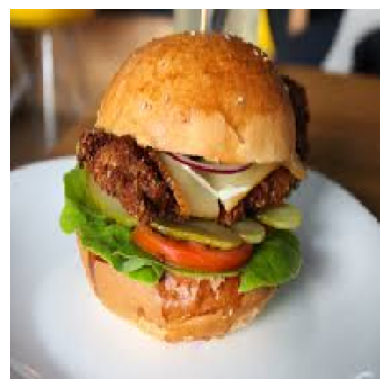

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

(ds_train, ds_val), ds_info = tfds.load(
    "food101",
    split=["train[:5%]", "validation[:5%]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

ds_train = ds_train.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(format_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(101, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(ds_train, epochs=3, validation_data=ds_val)

class_names = ds_info.features["label"].names

calorie_dict = {
    'apple_pie': 237,
    'baby_back_ribs': 400,
    'baklava': 290,
    'beef_carpaccio': 170,
    'beef_tartare': 180,
    'caesar_salad': 180,
    'cheesecake': 321,
    'chicken_curry': 165,
    'chicken_wings': 290,
    'chocolate_cake': 371,
    'club_sandwich': 300,
    'donuts': 452,
    'french_fries': 312,
    'hamburger': 354,
    'hot_dog': 290,
    'lasagna': 135,
    'macaroni_and_cheese': 164,
    'omelette': 154,
    'pancakes': 227,
    'pizza': 266,

}

def predict_food_with_calories(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    preds = model.predict(img_array)
    class_id = tf.argmax(preds[0]).numpy()
    class_name = class_names[class_id]
    calories = calorie_dict.get(class_name, "N/A")

    print(f"🍽️ Predicted Food: {class_name.replace('_', ' ').title()}")
    print(f"🔥 Estimated Calories: {calories} kcal per serving")

    plt.imshow(img)
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    predict_food_with_calories("burger.jpg")
